<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
import time

import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")


nltk.download("popular")
print(tf.__version__)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [15]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_def.csv", sep='#',encoding='utf-8', lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime_def_3.csv", sep='#', encoding='utf-8')

In [16]:
taste['id'] = taste['id'].astype(int)

In [17]:
taste.shape

(2065, 3)

In [18]:
# Merge taste and credits

data = taste.merge(dataover[['id','title','overview','genres','crew','cast']], left_on='id', right_on='id')

In [19]:
data = data[~pd.isna(data.overview)]
len(data)

2109

In [20]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)

data = data.drop_duplicates(subset=['id'])

data['text_array'] = data.overview.str.split(" ")
data['n_words'] = data['text_array'].apply(lambda x: len(x))
data = data.drop(columns=['text_array'])
#data = data[data['n_words']>15]
data.reset_index(inplace=True,drop=True)

len(data)

2043

# Dataset splitting
We are going to split our dataset in three parts (Train, Test and Validation).
Each part must mantain the same distribution as the original dataset. Same number of 0's and 1's in "like" column. This is achieved by the stratify parameter. 
- Train: 60% of the dataset.
- Test 20% of the dataset.
- Val: 20% of the dataset.


In [21]:
from sklearn.model_selection import train_test_split

X = data['overview'].values
y = data['like'].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=10)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

In [23]:
X_test[:5]

array(['Cuatro hombres trabajan en un garaje construyendo aparatos altamente complejos. En parte por accidente y en parte por su pericia, descubren un mecanismo dotado de poderes que les permite conseguir casi todo lo que quieran. Se trata de un hallazgo que podría cambiar el mundo, pero que pondrá a prueba las relaciones entre sus inventores.',
       'Aloys Adorn es un detective privado taciturno, un lobo solitario cuyo trabajo consiste en filmar a otras personas, observándolas en secreto y permaneciendo invisible. Un día se emborracha y se duerme en un autobús y, al despertarse, descubre que su cámara y sus cintas han sido robadas. La misteriosa mujer que le llama poco después parece tener algo que ver con ello. (FILMAFFINITY)',
       'Tres criminales, procedentes del planeta Krypton, a los que el padre de Superman condenó a vagar por el espacio, eluden su condena y se dirigen a la Tierra para enfrentarse a Superman, en una batalla cósmica por la supremacía sobre el planeta. Al mis

# Check distribution

To check the distribution and particulary check that test and validation has the same proportions we are going to draw 4 values for each sample:
- Lengh of the sample ("n_examples").
- Number of 0's in "like" column ("n_0").
- Number of 1's in "like" column ("n_1").
- Ratio between number of 1's and 0's ("ratio"). It is calculated by this formula: $(n_0 / n_1)*100$. It's neccesary to multiply it by 100 for seeing in the same scale and in the same figure than the other values.



In [24]:
# Check distribution (Andrew NG Book (train, test, val))

df_distribution = pd.DataFrame(columns=['sample','n_examples', 'n_0', 'n_1', 'ratio (n_1/n_0)*100']) 

# Train
examples = len(X_train)
n_0 = (y_train == 0).sum()
n_1 = (y_train == 1).sum()
ratio = (y_train == 1).sum() / (y_train == 0).sum()
new_row = {'sample': 'Train','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
df_distribution = df_distribution.append(new_row, ignore_index=True)

# Test
examples = len(X_test)
n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
ratio = (y_test == 1).sum() / (y_test == 0).sum()
new_row = {'sample': 'Test','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
df_distribution = df_distribution.append(new_row, ignore_index=True)

# Val
#examples = len(X_val)
#n_0 = (y_val == 0).sum()
#n_1 = (y_val == 1).sum()
#ratio = (y_val == 1).sum() / (y_val == 0).sum()
#new_row = {'sample': 'Val','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
#df_distribution = df_distribution.append(new_row, ignore_index=True)

df_distribution = df_distribution.set_index('sample').loc[['Test', 'Train']]

In [25]:
df_distribution

# 80% train - val
# 60% train
# 20% test
# 20% val

,n_examples,n_0,n_1,ratio (n_1/n_0)*100
sample,,,,
Test,613,336,277,82.440476
Train,1430,783,647,82.630907


You can see that the ratio is the same in the three cases and between test and val you have all the same values and cosecuently they have the same distribution.

If the distribution were not the same, it would be imposible to compare between train and validation and this will affect in the model performance because we will obtain dispair metrics for each sample.

(Andrew NG Book)


*¿Mirar distribución en cuanto al número de palabras en las oraciones, volumenes de cada una de las palabras en cada sample...?*

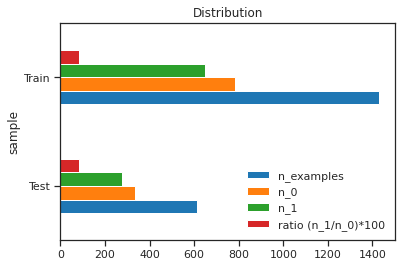

In [26]:
df_distribution.plot(y=['n_examples', 'n_0', 'n_1', 'ratio (n_1/n_0)*100'], kind='barh', title='Distribution')

In [27]:
data.head(5).to_latex()

"\\begin{tabular}{lrrrlllllr}\n\\toprule\n{} &  Unnamed: 0 &  id &  like &                                              title &                                           overview &                                             genres &                                               crew &                                               cast &  n\\_words \\\\\n\\midrule\n0 &           0 &   5 &     0 &                                         Four Rooms &  Durante una Nochevieja, en un hotel de Los Áng... &  [\\{'id': 80, 'name': 'Crimen'\\}, \\{'id': 35, 'nam... &  [\\{'credit\\_id': '52fe420dc3a36847f800011b', 'de... &  [\\{'cast\\_id': 42, 'character': 'Ted the Bellhop... &       73 \\\\\n1 &           1 &  11 &     1 &  La guerra de las galaxias. Episodio IV: Una nu... &  La princesa Leia, líder del movimiento rebelde... &  [\\{'id': 12, 'name': 'Aventura'\\}, \\{'id': 28, 'n... &  [\\{'credit\\_id': '52fe420dc3a36847f8000437', 'de... &  [\\{'cast\\_id': 3, 'character': 'Luke Skywalker',.

# Vectorize text

We are going to vectorize the overviews using a method call Bag of word (https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras). We have a vector for each sentence which consists in a vector with the lenght of the total vocabulary of the overviews, and have the count of how many times the word is appearing in this overview in concrete.

We obtain a very sparse matrix that we will see how to deal with in the next experiments.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

NameError: ignored

In [29]:
len(vectorizer.vocabulary_)

16683

In [30]:
#vectorizer.vocabulary_
#{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

# Deep learning model

Let's give it a try with a very simple neural network with the input and 2 dense layers.
- Input Layer: its the input of the neural network, batch with dimension of 10146.
- Dense Layer 1: recieve the input and returns 2 dimensions (only have 2 neurons fully conected to the input).
- Dense Layer 2: recieve the 2 previous dimensions and return 1 value with the probability between 0 and 1.

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(15, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

Parameters of the model

In [32]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                250260    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 250,276
Trainable params: 250,276
Non-trainable params: 0
_________________________________________________________________


In [33]:
#(input * weights_dense_1 + bias_dense_1) + (output_dense_1 * weights_dense_2 + bias_dense_2)

parameters_dense_1 = (10146 * 2 + 2)
parameters_dense_2 = (2 * 1 + 1)
total_parameters =  parameters_dense_1 + parameters_dense_2
total_parameters

20297

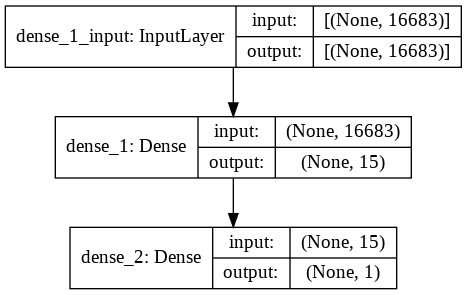

In [34]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
epochs = 8
batch_size = 4

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/8
358/358 [==============================] - 5s 4ms/step - loss: 0.6966 - accuracy: 0.5137 - val_loss: 0.6653 - val_accuracy: 0.6166
Epoch 2/8
358/358 [==============================] - 1s 3ms/step - loss: 0.6198 - accuracy: 0.7761 - val_loss: 0.6076 - val_accuracy: 0.7423
Epoch 3/8
358/358 [==============================] - 1s 3ms/step - loss: 0.5063 - accuracy: 0.9092 - val_loss: 0.5526 - val_accuracy: 0.7847
Epoch 4/8
358/358 [==============================] - 1s 3ms/step - loss: 0.3961 - accuracy: 0.9672 - val_loss: 0.5068 - val_accuracy: 0.8075
Epoch 5/8
358/358 [==============================] - 1s 3ms/step - loss: 0.3114 - accuracy: 0.9717 - val_loss: 0.4742 - val_accuracy: 0.8140
Epoch 6/8
358/358 [==============================] - 1s 3ms/step - loss: 0.2497 - accuracy: 0.9873 - val_loss: 0.4508 - val_accuracy: 0.8091
Epoch 7/8
358/358 [==============================] - 1s 3ms/step - loss: 0.1865 - accuracy: 0.9945 - val_loss: 0.4326 - val_accuracy: 0.8140
Epoch 8/8
358

During training the neural network try to optimize the error (Gradient descent). Loss value is going to be lower each interaction until overfitting of training dataset.

https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9

Text(4.65, 0.9469230484962463, '0.98')

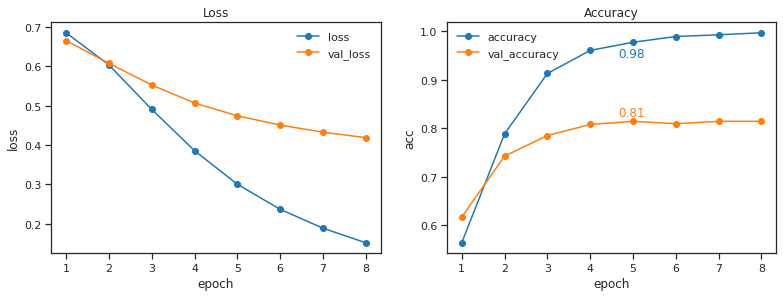

In [58]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
#for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
#  if y <0.43:
#   ax1.text(x = x - 0.35, # x-coordinate position of data label
#            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
#            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
#            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)

x = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()]

first_max_acc = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()].iloc[0]
x = first_max_acc['epoch']
y = first_max_acc['val_accuracy']
z = first_max_acc['accuracy']

ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
         color = 'tab:orange') # set colour of line
ax2.text(x = x - 0.35, # x-coordinate position of data label
         y = z - 0.03, # y-coordinate position of data label, adjusted to be 150 below the data point
         s = '{:.2f}'.format(z), # data label, formatted to ignore decimals
         color = 'tab:blue') # set colour of line

# Metrics
The metrics are very important in order to select the better model. (Andrew NG Book). This is a classification problem so we have to chose clasification metrics. https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

We are going to consider the following metrics in order to compare the following models:
- Accuracy: https://developers.google.com/machine-learning/crash-course/classification/accuracy
- AUC: Area under the ROC Curve. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Other metrics to consider could be:
- Precision
- Recall
- F1-score

Hands on Machine Learning (Bibliografy)

In [59]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.814
Precision: 0.841
Recall: 0.7256
F1: 0.7791
Conf. Matrix: 
[[298  38]
 [ 76 201]]


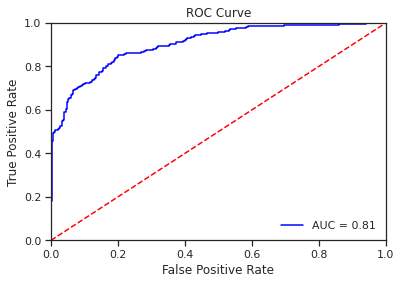

AUC: 0.8063


In [60]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

# Original Metrics results:

- Vocabulary: 16994
- Accuracy: 84%
- AUC: 84%
- Precision: 90%
- Recall: 75%
- F1: 82%

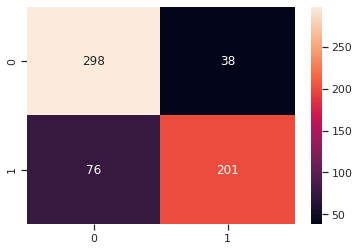

In [61]:
matrix_con = confusion_matrix(y_true, y_pred)
sns.heatmap(matrix_con, annot=True, fmt='g')

In [62]:
df_results = pd.DataFrame(columns=['Experimento', 'N palabras', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1'])

new_row = {'Experimento': 'Orig. + BOW + Dense','N palabras': 16994,'Accuracy':84, 'AUC':84, 'Precision':90, 'Recall':75, 'F1':82}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Stem. + BOW + Dense','N palabras': 7939,'Accuracy':87, 'AUC':87, 'Precision':89, 'Recall':85, 'F1':87}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Text Aug. + Stem. + BOW + Dense','N palabras': 10000,'Accuracy':88, 'AUC':88, 'Precision':90, 'Recall':86, 'F1':88}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Word Emb. + CNN','N palabras': 10000,'Accuracy':90, 'AUC':90, 'Precision':90, 'Recall':86, 'F1':88}
df_results = df_results.append(new_row, ignore_index=True)

df_results

,Experimento,N palabras,Accuracy,AUC,Precision,Recall,F1
0,Orig. + BOW + Dense,16994,84,84,90,75,82
1,Stem. + BOW + Dense,7939,87,87,89,85,87
2,Text Aug. + Stem. + BOW + Dense,10000,88,88,90,86,88
3,Word Emb. + CNN,10000,90,90,90,86,88


Vocabulary

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

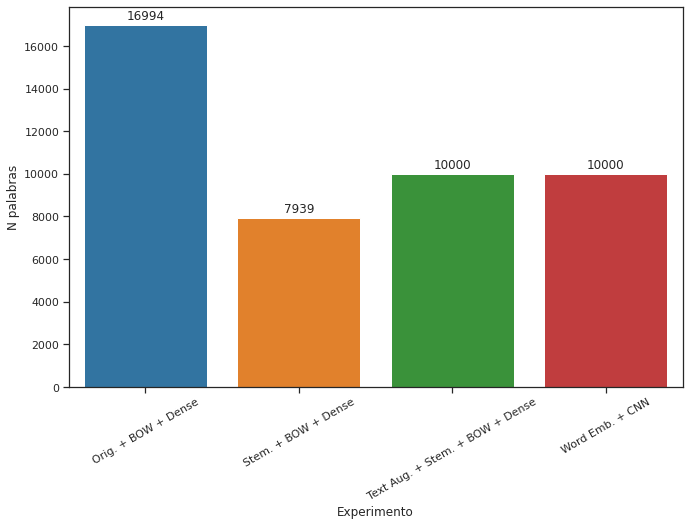

In [63]:
fig, ax = plt.subplots(figsize=(11, 7))
splot = sns.barplot(x="Experimento", y="N palabras", data=df_results, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=30)

Vocabulary vs acc

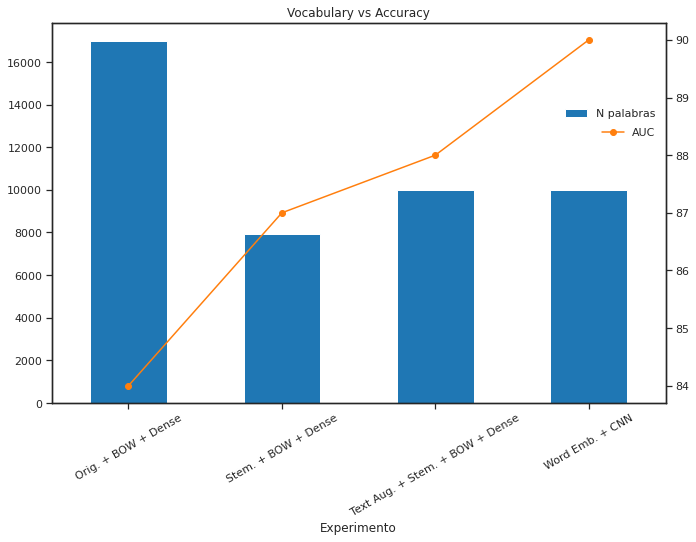

In [64]:
fig, ax1 = plt.subplots(figsize=(11, 7))
df_results.plot(kind='bar', x='Experimento', y='N palabras', title='Vocabulary vs Accuracy', rot=30, ax=ax1).legend(bbox_to_anchor=(1,0.80), loc="upper right")
ax2 = ax1.twinx()
df_results.plot(kind='line', x='Experimento', y='AUC', color='tab:orange', marker='o', secondary_y=True, ax=ax2, legend=False).legend(bbox_to_anchor=(1,0.75), loc="upper right")

Metrics

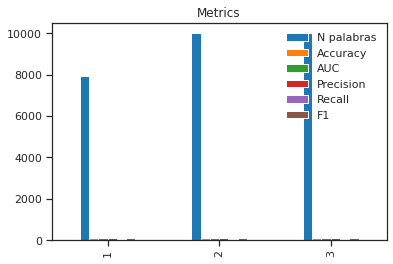

In [65]:
df_results.iloc[1:].plot(kind='bar', title='Metrics')